# Feature engineering

## Cargando librerías

In [1]:
import pandas as pd
import pickle
import datetime
import time
import numpy as np
import math as m

In [58]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.linear_model import LogisticRegression

In [3]:
from sklearn.tree import DecisionTreeClassifier
from siuba import *

## Funciones de ingesta y transformación

In [4]:
# Funciones solicitadas

def load_ingestion(path='output/ingest_df.pkl'):
    """
    Recibe el path en donde se encuentra el pickle que generamos durante la ingestión.
    :param: path
    :return: pickle
    """
    # Recibe ingest_df.pkl
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def generate_label(df):
    """
    Crea en el data frame de los datos la variable label que es 1
    cuando el código de cierre es 'Pass','Pass w/ Conditions', 0 en caso de 'Fail'.
    :param: dataframe
    :return: dataframe
    """
    df['label'] = np.where(df.results.isin(['Pass','Pass w/ Conditions']), 1, 0)
    return df


def date_transformation(col, df):
    """
    Recibe la columna que hay que transformar a DATE y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return pd.to_datetime(df[col])

def numeric_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(float) 

def int_transformation(col, df):
    """
    Recibe la columna que hay que transformar a NUMERIC (entera) y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(int)

def categoric_trasformation(col, df):
    """
    Recibe la columna que hay que transformar a CATEGORICA y el data frame al que pertenece.
    :param: column, dataframe
    :return: column
    """
    return df[col].astype(str) 

  
def save_transformation(df, path='output/transformation_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb)
    el data frame que ya tiene los datos transformados.
    El pickle se debe llamar transformation_df.pkl y se debe guardar
    en la carpeta output.
    :param: dataframe, path
    :return: file save
    """
    pickle.dump(df, open(path, "wb"))
    # utils function, debería guardar el pickle llamado transformation_df.pkl en la carpeta ouput
    # save_df(df, path)

## Funciones de feature enginering

In [21]:
# Funciones solicitadas

def load_transformation(path='output/transformation_df.pkl'): 
    """
    Recibe el path en donde se encuentra el pickle que generamos 
    durante la transformación.
    """
    df_pkl = pickle.load(open(path, "rb"))
    return df_pkl
    # utils function
    #load_df(path)
    
def feature_generation(data): 
    """
    Recibe el data frame que contiene las variables a partir de las cuales 
    crearemos nuevas variables. Estas nuevas variables se guardarán en este 
    mismo data frame.
    """    
    # Creación de variables
    # Dividiendo fecha en mes y día, y creando semanas
    data = split_fecha("inspection_date", data)
    
    # Para crear variables ciclícas
    data = ciclic_variables('day_of_week', data)
    data = ciclic_variables('week', data)
    data = ciclic_variables('inspection_date_mes', data)
    data = ciclic_variables('inspection_date_dia', data)
    
    # Distancia al centroide
    data = get_distance(data)
    
    # Variables posibles a transformar
    """
    'type_insp','type','risk','zip','weekday','distance',
    'sin_day_no','cos_day_no','sin_week','cos_week',
    'sin_month','cos_month','sin_days','cos_days'
    """
    # Variables a transformar
    data_input = pd.DataFrame(data,
                              columns=['type_insp','type','risk','zip','weekday',
                                       'distance','distancia_ym_mht','distancia_ym',
                                       'sin_day_no','cos_day_no','sin_week','cos_week',
                                       'sin_month','cos_month','sin_days','cos_days'])
    # Transformaciones
    transformers_2 = [('one_hot', OneHotEncoder(), ['type_insp','type','risk','zip','weekday']),
                      ('min_max', MinMaxScaler(), ['distance','distancia_ym_mht','distancia_ym' ]),
                      ('r_original', NoTransformer(), ['sin_day_no','cos_day_no','sin_week','cos_week',
                                                       'sin_month','cos_month','sin_days','cos_days'])]

    col_trans_2 = ColumnTransformer(transformers_2, remainder="drop", n_jobs=-1, verbose=True)
    col_trans_2.fit(data_input)

    input_vars = col_trans_2.transform(data_input)    
    # Solo para medir metricas
    pickle.dump(input_vars, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

    cols = ['Canvass', 'Complaint', 'Consultation', 'License',
           'LicenseTaskForce-PreLicenseConsultation', 'Other',
           'Package liquor 1474', 'Recent inspection',
           'Special events (festivals)', 'Suspected food poisoning', 'Tag removal','Task force',
            
            'AssistanceService', 'BanquetService-Church', 'Bar', 'CoffeShop',
            'Drug-Grocery', 'EntertainmentServices', 'GasStation-Grosery',
            'Grocery-Almacen-ConvenienceStore', 'HealthStore', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'All','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            
            '60148', '60406', '60501', '60601', '60602', '60603', '60604', '60605',
           '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613',
           '60614', '60615', '60616', '60617', '60618', '60619', '60620', '60621',
           '60622', '60623', '60624', '60625', '60626', '60627', '60628', '60629',
           '60630', '60631', '60632', '60633', '60634', '60636', '60637', '60638',
           '60639', '60640', '60641', '60642', '60643', '60644', '60645', '60646',
           '60647', '60649', '60651', '60652', '60653', '60654', '60655', '60656',
           '60657', '60659', '60660', '60661', '60666', '60707', '60827',
            
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance','distancia_ym_mht','distancia_ym',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

    # Información del dataframe final
    df_final = pd.DataFrame(input_vars.todense())
    df_final.columns = cols    
        
    #df_final['inspection_date']= data['inspection_date']
    df_final['label']= data['label']
    
    return df_final
   
    
def feature_selection(data): 
    """
    Recibe el data frame que contiene las variables de las cuales haremos
    una selección.
    """
    X = data
    y = data.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    
    np.random.seed(20201124)

    ## Dividiendo datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # ocuparemos un RF
    classifier = RandomForestClassifier(oob_score=True, random_state=1234)

    # Definicion de los hiperparametros que queremos probar
    hyper_param_grid = {'n_estimators': [100, 300],
                        'max_depth': [1, 10, 15],
                        'min_samples_split': [2, 5]}

    tscv = TimeSeriesSplit(n_splits=3)
    
    # Ocupemos grid search!
    gs = GridSearchCV(classifier,
                      hyper_param_grid,
                      scoring='precision',
                      cv = tscv,
                      n_jobs = 3)

    # ejecutando el RF
    start_time = time.time()
    gs.fit(X_train, y_train)
    print("El proceso en segundos duro: ", time.time() - start_time)
    print("Mejores parámetros: " + str(gs.best_params_))
    print("Score:" + str(print(gs.best_score_)))
    best_e = gs.best_estimator_
    print("Mejor estimador: " + str(best_e))
    print("Mejor estimador observado: " + str(gs.best_estimator_.oob_score_))
        
    cols = ['Canvass', 'Complaint', 'Consultation', 'License',
           'LicenseTaskForce-PreLicenseConsultation', 'Other',
           'Package liquor 1474', 'Recent inspection',
           'Special events (festivals)', 'Suspected food poisoning', 'Tag removal','Task force',
            
            'AssistanceService', 'BanquetService-Church', 'Bar', 'CoffeShop',
            'Drug-Grocery', 'EntertainmentServices', 'GasStation-Grosery',
            'Grocery-Almacen-ConvenienceStore', 'HealthStore', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'All','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            
            '60148', '60406', '60501', '60601', '60602', '60603', '60604', '60605',
           '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613',
           '60614', '60615', '60616', '60617', '60618', '60619', '60620', '60621',
           '60622', '60623', '60624', '60625', '60626', '60627', '60628', '60629',
           '60630', '60631', '60632', '60633', '60634', '60636', '60637', '60638',
           '60639', '60640', '60641', '60642', '60643', '60644', '60645', '60646',
           '60647', '60649', '60651', '60652', '60653', '60654', '60655', '60656',
           '60657', '60659', '60660', '60661', '60666', '60707', '60827',
            
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance','distancia_ym_mht','distancia_ym',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']


    # Importancia de los parámetros
    feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                       'feature': list(cols)})
    print("Importancia de los parámetros")
    print(feature_importance.sort_values(by="importance", ascending=False))

    # Salvando el mejor modelo obtenido
    #save_fe(best_e, path='../output/feature_selection_model_DPA.pkl')
    save_fe(best_e, path='output/feature_selection_model_DPA.pkl')

    # Regresando dataframe con los features que ocuparemos.
    # En este caso las variables que aportan más del 7% de información son:
    final_df = data[[
                            # Variables que aportan 7%
                            'distance','distancia_ym_mht','distancia_ym',
                            'sin_days','cos_days',
                            'sin_week','cos_week',    
                            # Variables que aportan 4% y 3%
                            'sin_day_no','cos_day_no','sin_month','cos_month',
                            # Variables que aportan 1.5% aprox
                            'All','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
                            
                            'Canvass', 'Complaint', 'Consultation', 'License',
           'LicenseTaskForce-PreLicenseConsultation', 'Other',
           'Package liquor 1474', 'Recent inspection',
           'Special events (festivals)', 'Suspected food poisoning', 'Tag removal','Task force',
        
                            'AssistanceService', 'BanquetService-Church', 'Bar', 'CoffeShop',
                            'Drug-Grocery', 'EntertainmentServices', 'GasStation-Grosery',
                            'Grocery-Almacen-ConvenienceStore', 'HealthStore', 'Kiosko', 'Others',
                            'Restaurant', 'School',
        
                            'label'
                         ]]    

    return final_df

    
def save_fe(df, path='output/fe_df.pkl'):
    """
    Guarda en formato pickle (ver notebook feature_engineering.ipynb) el data frame 
    que ya tiene los features que ocuparemos. El pickle se debe llamar fe_df.pkl y 
    se debe guardar en la carpeta output.
    """    
    pickle.dump(df, open(path, "wb"))##en jupyter
    # utils function, debería guardar el picjle llamado fe_df.pkl en la carpeta ouput
    #save_df(df, path)# en .py
    

# --------------------- Funciones Auxiliares ---------------------------   
# Para conservar el mismo valor
class NoTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X
    
def split_fecha(col, df):
    """
    Recibe la columna fecha que hay que transformar en 3 columnas: año, mes, dia y 
    el data frame al que pertenece.
    :param: column, dataframe
    :return: dataframe con 2 columnas mas (mes, día) y semanas
    """
    df[col + '_anio'] = df[col].dt.year.astype(str) 
    df[col + '_mes'] = df[col].dt.month.astype(str) 
    df[col + '_dia'] = df[col].dt.day.astype(str)     
    
    # Cambio a enteros
    df[col + '_anio'] = int_transformation(col + '_anio', df)
    df[col + '_mes'] = int_transformation(col + '_mes', df)
    df[col + '_dia'] = int_transformation(col + '_dia', df)
    
    df['week'] = df[col].dt.week
    df['day_of_week'] = df[col].dt.day_name()
    
    # Fines de semana 
    df['weekday']=df[col].map(lambda x: 'Y' if x.weekday()<5 else 'N')
    print('weekday')
    print(df_transform.weekday.unique())
    
    return df


def get_distance(df):
    """
    Genera centroide de latitud y longitu con medias y calcula distancias
    :param: dataframe
    :return: dataframe
    """
    lat_c = df['latitude'].median()
    lon_c = df['longitude'].median()
    
    df['lat'] = lat_c- df['latitude'].astype(float) 
    df['lon'] = lon_c - df['longitude'].astype(float) 

#     df['lat'] = lat_c.astype(float) - df['latitude'].astype(float) 
#     df['lon'] = lon_c.astype(float) - df['longitude'].astype(float) 
    
    df['distance'] = np.sqrt(df['lat']**2+df['lon']**2)
    
    df = (df
        >> group_by (_.inspection_date_anio, _.inspection_date_mes) 
        >> mutate(mediana_ym_lat = _.latitude.median(), mediana_ym_lon = _.longitude.median())
        >> ungroup()
        >> mutate(distancia_ym = ( (_.mediana_ym_lat - _.latitude)**2 +  (_.mediana_ym_lon - _.longitude)**2 ) **(1/2) )
        >> mutate(distancia_ym_mht = abs (_.mediana_ym_lat - _.latitude) +  abs(_.mediana_ym_lon - _.longitude) ) )

    df = pd.DataFrame(df.drop(['lat','lon','mediana_ym_lat', 'mediana_ym_lon'], axis=1))
    
    return df

def ciclic_variables(col, df):
    """
    Recibe la columna day_no, mes o fecha_creacion y las convierte en variables cíclicas:
    número día de la semana, mes, semana y hora respectivamente.
    :param: column, dataframe
    :return: dataframe con variable cíclica creada corresondientemente
    """
    
    if (col == 'day_of_week'):
        no_dia_semana = {'Sunday':1, 'Monday':2, 'Tuesday':3, 'Wednesday':4, 
                         'Thursday':5, 'Friday':6, 'Saturday':7}
        df['day_no'] = df[col].apply(lambda x: no_dia_semana[x])
        #max_day_no = np.max(df['day_no'])
        max_day_no = 7
        df['sin_day_no'] = np.sin(2*np.pi*df['day_no']/max_day_no)
        df['cos_day_no'] = np.cos(2*np.pi*df['day_no']/max_day_no)
        
    if(col == 'week'):
        # converting the hour into a sin, cos coordinate
        WEEKS = 53
        df['sin_week'] = np.sin(2*np.pi*df[col]/WEEKS)
        df['cos_week'] = np.cos(2*np.pi*df[col]/WEEKS) 
        
    if(col == 'inspection_date_mes'):
        MONTH = 12
        df['sin_month'] = np.sin(2*np.pi*df[col]/MONTH)
        df['cos_month'] = np.cos(2*np.pi*df[col]/MONTH) 
        
    if(col == 'inspection_date_dia'):
        # converting the hour into a sin, cos coordinate
        DAYS = 31
        df['sin_days'] = np.sin(2*np.pi*df[col]/DAYS)
        df['cos_days'] = np.cos(2*np.pi*df[col]/DAYS)    
            
    return df
    


In [6]:
def clean(df):
    """
    Recibe un dataframe y le aplica limpieza de datos
    :param: dataframe
    :return: dataframe
    """    
    
    # Nos quedamos sólo con los resultados 'Pass','Pass w/ Conditions', 'Fail
    df = df[df.results.isin(['Pass','Pass w/ Conditions', 'Fail'])]     
    
    # Quitamos NA
    df = df[df['inspection_type'].notna()]
    df = df[df['facility_type'].notna()]
    df = df[df['risk'].notna()]
    df = df[df['city'].notna()]
    df = df[df['state'].notna()]
    df = df[df['zip'].notna()]
    df = df[df['latitude'].notna()]
    df = df[df['longitude'].notna()]
    df = df[df['location'].notna()]
        
    # Agrupamos tipo inspecciones AGREGADO
    df = agrupa_inspeciones_tipo(df)  
    
    # Agrupamos establecimientos
    df = agrupa_tipos(df)  
    
    # Quitamos duplicados
    #df = df.drop_duplicates()
    
    # Podemos tomar sólo los de tipo Canvass (Sondeo)
    #df = df[df.inspection_type.isin(['Canvass','CANVAS'])]
    
    # Generamos el label
    df = generate_label(df)
    
    # Nos quedamos con las variables para predecir 
    df = df[['type_insp','type','risk', 'zip',
             'inspection_date','latitude','longitude','label']]  
    
    return df

def agrupa_inspeciones_tipo(df_final):
    """
    Agrupa los tipos de establecimientos
    :param: dataframe
    :return: dataframe
    """
    
    # Se pasa a minúsculas
    df_final["inspection_type"] = df_final["inspection_type"].str.lower().str.strip()
    # Se hace una copia de la variable
    df_final["type_insp"] = df_final["inspection_type"]
    
    # Podemos tomar sólo las que no esten en
    df_final = df_final[~df_final.type_insp.isin(["addendum","business not located","changed court date",
                                "duplicated","error save","no entry","non-inspection",
                                "not ready","out of business","out ofbusiness"])]
        
    # Comenzamos a agrupar
    df_final['type_insp'] = df_final['type_insp'].replace(["canvas",
                                                "canvass",
                                                "canvass for rib fest",
                                                "canvass re inspection of close up",
                                                "canvass re-inspection",
                                                "canvass school/special event",
                                                "canvass special events",
                                                "canvass/special event"],"Canvass")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["close-up/complaint reinspection",
                                                        "complaint",
                                                        "complaint re-inspection",
                                                        "complaint-fire",
                                                        "complaint-fire re-inspection",
                                                        "covid complaint",
                                                        "finish complaint inspection from 5-18-10",
                                                        "fire complaint",
                                                        "fire/complain",
                                                        "no entry-short complaint)",
                                                        "sfp/complaint",
                                                        "short form complaint",
                                                        "short form fire-complaint",
                                                        "smoking complaint"],"Complaint")
    
    
    df_final['type_insp'] = df_final['type_insp'].replace(["consultation"],
                                                          "Consultation")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["1315 license reinspection",
                                                        "day care license renewal",
                                                        "license",
                                                        "license consultation",
                                                        "license daycare 1586",
                                                        "license re-inspection",
                                                        "license renewal for daycare",
                                                        "license renewal inspection for daycare",
                                                        "license request",
                                                        "license task 1474",
                                                        "license task force / not -for-profit clu",
                                                        "license task force / not -for-profit club",
                                                        "license wrong address",
                                                        "license/not ready",
                                                        "owner suspended operation/license",
                                                        "tavern 1470"],"License")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["license-task force",
                                                          "pre-license consultation"],
                                                          "LicenseTaskForce-PreLicenseConsultation")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["package liquor 1474"],
                                                          "Package liquor 1474")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["recent inspection"],
                                                          "Recent inspection")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["special events (festivals)"],
                                                          "Special events (festivals)")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["suspected food poisoning",
                                                           "suspected food poisoning re-inspection"],
                                                          "Suspected food poisoning")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["tag removal"],
                                                          "Tag removal")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["liqour task force not ready",
                                                            "special task force",
                                                            "task force",
                                                            "task force for liquor 1474",
                                                            "task force liquor (1481)",
                                                            "task force liquor 1470",
                                                            "task force liquor 1474",
                                                            "task force liquor 1475",
                                                            "task force liquor catering",
                                                            "task force liquor inspection 1474",
                                                            "task force night",
                                                            "task force not ready",
                                                            "task force package goods 1474",
                                                            "task force package liquor",
                                                            "task force(1470) liquor tavern",
                                                            "taskforce"],
                                                            "Task force")
    
    df_final['type_insp'] = df_final['type_insp'].replace(["citation re-issued",
                                                            "citf",
                                                            "corrective action",
                                                            "expansion",
                                                            "haccp questionaire",
                                                            "illegal operation",
                                                            "kids cafe",
                                                            "kids cafe'",
                                                            "liquor catering",
                                                            "office assignment",
                                                            "possible fbi",
                                                            "recall inspection",
                                                            "reinspection",
                                                            "reinspection of 48 hour notice",
                                                            "re-inspection of close-up",
                                                            "sample collection",
                                                            "sfp",
                                                            "sfp recently inspected",
                                                            "summer feeding",
                                                            "taste of chicago",
                                                            "two people ate and got sick."],"Other")
                                                          
    return df_final
                                                          

def agrupa_tipos(df_final):
    """
    Agrupa los tipos de establecimientos
    :param: dataframe
    :return: dataframe
    """
    # Se pasa a minúsculas
    df_final["facility_type"] = df_final["facility_type"].str.lower().str.strip()
    # Se hace una copia de la variable
    df_final["type"] = df_final["facility_type"]
    # Comenzamos a agrupar
    df_final['type'] = df_final['type'].replace(["1005 nursing home",
                                                "1023",
                                                "1023 childern's service facility",
                                                "1023 childern's service s facility",
                                                "1023 childern's services facility",
                                                "1023 children's services facility",
                                                "1023-children's services facility",
                                                "15 monts to 5 years old",
                                                "1584-day care above 2 years",
                                                "adult daycare",
                                                "adult family care center",
                                                "assissted living",
                                                "assisted living",
                                                "assisted living senior care",
                                                "catering",
                                                "charity aid kitchen",
                                                "childern activity facility",
                                                "childern's service facility",
                                                "childern's services  facility",
                                                "childrens services facility",
                                                "children's services facility",
                                                "day care",
                                                "day care 1023",
                                                "day care 2-14",
                                                "daycare",
                                                "daycare (2 - 6 years)",
                                                "daycare (2 years)",
                                                "daycare (under 2 years)",
                                                "daycare 1586",
                                                "daycare 2 yrs to 12 yrs",
                                                "daycare 2-6, under 6",
                                                "daycare 6 wks-5yrs",
                                                "daycare above and under 2 years",
                                                "daycare combo",
                                                "daycare combo 1586",
                                                "daycare night",
                                                "long term care",
                                                "long term care facility",
                                                "long-term care",
                                                "long-term care facility",
                                                "non -profit",
                                                "nursing home",
                                                "rehab center",
                                                "senior day care",
                                                "shelter",
                                                "supportive living",
                                                "supportive living facility",
                                                "youth housing"
                                                ],"AssistanceService")

    df_final['type'] = df_final['type'].replace(["banquet",
                                                "banquet dining",
                                                "banquet facility",
                                                "banquet hall",
                                                "banquet hall/catering",
                                                "banquet room",
                                                "banquet rooms",
                                                "banquet/kitchen",
                                                "banquets",
                                                "banquets/room service",
                                                "bowling lanes/banquets",
                                                "catered events",
                                                "catering/banquet",
                                                "church",
                                                "church (special events)",
                                                "church kitchen",
                                                "church/day care",
                                                "church/special event",
                                                "church/special events",
                                                "event center",
                                                "event space",
                                                "event venu",
                                                "hooka lounge",
                                                "lounge",
                                                "lounge/banquet hall",
                                                "private event space",
                                                "religious",
                                                "special event"],"BanquetService-Church")

    df_final['type'] = df_final['type'].replace(["bar",
                                                "bar/grill",
                                                "brewery",
                                                "brewpub",
                                                "hooka bar",
                                                "juice and salad bar",
                                                "juice bar",
                                                "juice bar/grocery",
                                                "liqour brewery tasting",
                                                "liquor/grocery store/bar",
                                                "liquore store/bar",
                                                "massage bar",
                                                "protein shake bar",
                                                "restuarant and bar",
                                                "service bar/theatre",
                                                "shuffleboard club with bar",
                                                "smoothie bar",
                                                "tap room/tavern/liquor store",
                                                "tavern",
                                                "tavern/bar",
                                                "tavern/liquor",
                                                "tavern/store",
                                                "tavern-liquor",
                                                "theater/bar",
                                                "wine tasting bar",
                                                ],"Bar")

    df_final['type'] = df_final['type'].replace(["cafe",
                                                "cafe/store",
                                                "cafeteria",
                                                "catering/cafe",
                                                "coffee",
                                                "coffee  shop",
                                                "coffee cart",
                                                "coffee kiosk",
                                                "coffee roaster",
                                                "coffee shop",
                                                "coffee/tea",
                                                "kids cafe",
                                                "kids cafe'",
                                                "liquor/coffee kiosk",
                                                "riverwalk cafe"],"Coffe shop")

    df_final['type'] = df_final['type'].replace(["drug store",
                                                "drug store/grocery",
                                                "drug store/w/ food",
                                                "drug treatment facility",
                                                "drug/food store",
                                                "grocery/drug store",
                                                "pharmacy"],"Drug-Grocery")

    df_final['type'] = df_final['type'].replace(["art center",
                                                "art gallery",
                                                "art gallery w/wine and beer",
                                                "blockbuster video",
                                                "boys and girls club",
                                                "day spa",
                                                "movie theater",
                                                "movie theatre",
                                                "museum/gallery",
                                                "music venue",
                                                "night club",
                                                "not-for-profit club",
                                                "pool",
                                                "private club",
                                                "social club",
                                                "spa",
                                                "stadium",
                                                "theater",
                                                "theatre",
                                                "vfw hall",
                                                "video store"],"EntertainmentServices")

    df_final['type'] = df_final['type'].replace(["(gas station)",
                                                "convenience/gas station",
                                                "gas station",
                                                "gas station /grocery",
                                                "gas station /subway mini mart.",
                                                "gas station food store",
                                                "gas station store",
                                                "gas station/ grocery store",
                                                "gas station/convenience store",
                                                "gas station/food",
                                                "gas station/grocery",
                                                "gas station/mini mart",
                                                "gas station/restaurant",
                                                "gas station/store",
                                                "gas station/store grocery",
                                                "grocery store / gas station",
                                                "grocery store/gas station",
                                                "grocery(gas station)",
                                                "grocery/gas station",
                                                "grocery/service gas station",
                                                "retail food/gas station",
                                                "service gas station"],"GasStation-Grosery")

    df_final['type'] = df_final['type'].replace(["(convenience store)",
                                                "1475 liquor",
                                                "bakery",
                                                "bakery/deli",
                                                "bakery/grocery",
                                                "butcher shop",
                                                "candy",
                                                "candy maker",
                                                "candy shop",
                                                "candy store",
                                                "candy/gelato",
                                                "catered liquor",
                                                "catering and wholesale",
                                                "chinese herbs",
                                                "cold/frozen food storage",
                                                "commiasary",
                                                "commissary",
                                                "commissary for soft serve ice cream trucks",
                                                "convenience",
                                                "convenience store",
                                                "convenience/drug store",
                                                "convenient store",
                                                "convnience store",
                                                "deli",
                                                "deli/bakery",
                                                "deli/grocery",
                                                "deli/grocery store",
                                                "distribution center",
                                                "distributor",
                                                "donut shop",
                                                "exercise and nutrition bar",
                                                "fish market",
                                                "fitness center",
                                                "fitness studio",
                                                "food pantry",
                                                "food pantry/church",
                                                "french market space",
                                                "furniture store",
                                                "gelato shop",
                                                "general store",
                                                "golf course conncession stand",
                                                "grocery",
                                                "grocery and butcher",
                                                "grocery delivery service",
                                                "grocery store",
                                                "grocery store /pharmacy",
                                                "grocery store/deli",
                                                "grocery/bakery",
                                                "grocery/butcher",
                                                "grocery/cafe",
                                                "grocery/deli",
                                                "grocery/dollar store",
                                                "grocery/liquor",
                                                "grocery/liquor store",
                                                "gym",
                                                "gym store",
                                                "ice cream",
                                                "ice cream parlor",
                                                "ice cream shop",
                                                "kitchen demo",
                                                "liquor",
                                                "liquor consumption on premises.",
                                                "liquor store",
                                                "meat packing",
                                                "mexican candy store",
                                                "milk tea",
                                                "packaged food distribution",
                                                "packaged liquor",
                                                "paleteria",
                                                "paleteria /icecream shop",
                                                "pantry",
                                                "popcorn corn",
                                                "popcorn shop",
                                                "pre packaged",
                                                "prepacakaged foods",
                                                "prepackage meal distributor (1006 retail)",
                                                "produce stand",
                                                "produce vendor",
                                                "rest/grocery",
                                                "retail",
                                                "retail store",
                                                "retail store offers cooking classes",
                                                "shakes/teas",
                                                "slaughter house/ grocery",
                                                "snack shop",
                                                "store",
                                                "tea store",
                                                "tobacco store",
                                                "vending commissary",
                                                "warehouse",
                                                "watermelon house",
                                                "wholesale",
                                                "wholesale & retail",
                                                "wholesale bakery",
                                                "wine store"],"Grocery-Almacen-ConvenienceStore")

    df_final['type'] = df_final['type'].replace(["health care store",
                                                "health center",
                                                "health food store",
                                                "herabalife",
                                                "herbal",
                                                "herbal drinks",
                                                "herbal life",
                                                "herbal life shop",
                                                "herbal medicine",
                                                "herbal remedy",
                                                "herbal store",
                                                "herbalcal",
                                                "herbalife",
                                                "herbalife nutrition",
                                                "herbalife store",
                                                "herbalife/zumba",
                                                "hospital",
                                                "nutrition shakes",
                                                "nutrition store",
                                                "nutrition/herbalife",
                                                "packaged health foods",
                                                "repackaging plant",
                                                "weight loss program"],"HealthStore")

    df_final['type'] = df_final['type'].replace(["coffee vending machine",
                                                "food booth",
                                                "food vending machines",
                                                "frozen dessert pushcarts",
                                                "frozen desserts dispenser -non motorized",
                                                "frozen desserts dispenser-non-motorized",
                                                "hot dog cart",
                                                "hot dog station",
                                                "kiosk",
                                                "mfd truck",
                                                "mobil food 1315",
                                                "mobile dessert cart",
                                                "mobile dessert vendor",
                                                "mobile desserts vendor",
                                                "mobile food",
                                                "mobile food desserts vendor",
                                                "mobile food dispenser",
                                                "mobile food preparer",
                                                "mobile food truck",
                                                "mobile frozen dessert disp/non-motorized",
                                                "mobile frozen dessert dispenser_non  motorized.",
                                                "mobile frozen dessert vendor",
                                                "mobile frozen desserts dispenser-non- motorized",
                                                "mobile frozen desserts dispenser-non-motor",
                                                "mobile frozen desserts dispenser-non-motorized",
                                                "mobile frozen desserts vendor",
                                                "mobile prepared food vendor",
                                                "mobile push cart",
                                                "mobilprepared food vendor",
                                                "navy pier kiosk",
                                                "newsstand",
                                                "np-kiosk",
                                                "o'hare kiosk",
                                                "peddler",
                                                "pop-up food establishment user-tier ii",
                                                "pop-up food establishment user-tier iii",
                                                "push carts",
                                                "pushcart",
                                                "temporary kiosk",
                                                "truck",
                                                "vending machine"],"Kiosko")

    df_final['type'] = df_final['type'].replace(["bakery/ restaurant",
                                                "bakery/restaurant",
                                                "commisary restaurant",
                                                "dining hall",
                                                "employee kitchen",
                                                "golden diner",
                                                "grocery & restaurant",
                                                "grocery store/ restaurant",
                                                "grocery store/bakery",
                                                "grocery store/taqueria",
                                                "grocery& restaurant",
                                                "grocery(sushi prep)",
                                                "grocery/ restaurant",
                                                "grocery/restaurant",
                                                "grocery/taqueria",
                                                "kitchen",
                                                "main kitchen",
                                                "restaurant",
                                                "restaurant(protein shake bar)",
                                                "restaurant.banquet halls",
                                                "restaurant/bakery",
                                                "restaurant/bar",
                                                "restaurant/bar/theater",
                                                "restaurant/grocery",
                                                "restaurant/grocery store",
                                                "restaurant/hospital",
                                                "restaurant/liquor",
                                                "roof top",
                                                "roof tops",
                                                "rooftop",
                                                "rooftop patio",
                                                "rooftops",
                                                "shared kitchen",
                                                "shared kitchen user (long term)",
                                                "shared kitchen user (long trem)",
                                                "shared kitchen user (short term)",
                                                "smokehouse",
                                                "soup kitchen",
                                                "summer feeding",
                                                "summer feeding prep area",
                                                "sushi counter",
                                                "tavern grill",
                                                "tavern/restaurant",
                                                "tent rstaurant",
                                                "theater & restaurant",
                                                "wrigley roof top",
                                                "wrigley rooftop"],"Restaurant")

    df_final['type'] = df_final['type'].replace(["after school care",
                                                "after school program",
                                                "a-not-for-profit chef training program",
                                                "before and after school program",
                                                "charter",
                                                "charter school",
                                                "charter school cafeteria",
                                                "charter school/cafeteria",
                                                "church/after school program",
                                                "city of chicago college",
                                                "college",
                                                "cooking school",
                                                "culinary arts school",
                                                "culinary class rooms",
                                                "culinary school",
                                                "grocery store/cooking school",
                                                "high school kitchen",
                                                "pastry school",
                                                "prep inside school",
                                                "private school",
                                                "public shcool",
                                                "school",
                                                "school cafeteria",
                                                "teaching school",
                                                "university cafeteria"],"School")

    df_final['type'] = df_final['type'].replace(["",
                                                "airport lounge",
                                                "animal shelter cafe permit",
                                                "beverage/silverware warehouse",
                                                "car wash",
                                                "cell phone store",
                                                "chicago park district",
                                                "clothing store",
                                                "custom poultry slaughter",
                                                "dollar & grocery store",
                                                "dollar store",
                                                "dollar store with grocery",
                                                "dollar tree",
                                                "farmer's market",
                                                "gift shop",
                                                "golf course",
                                                "greenhouse",
                                                "hair salon",
                                                "helicopter terminal",
                                                "hostel",
                                                "hotel",
                                                "illegal vendor",
                                                "incubator",
                                                "internet cafe",
                                                "laundromat",
                                                "linited business",
                                                "live butcher",
                                                "live poultry",
                                                "nail shop",
                                                "non-for profit basement kit",
                                                "northerly island",
                                                "not for profit",
                                                "other",
                                                "pop-up establishment host-tier ii",
                                                "poultry slaughter",
                                                "regulated business",
                                                "rest/gym",
                                                "rest/rooftop",
                                                "riverwalk",
                                                "room service",
                                                "unlicensed facility",
                                                "unused storage",
                                                "urban farm"],"Others")
    return df_final

# Transformation.py

## Carga de datos

In [7]:
data = pickle.load(open('output/2020-02-02_.pkl', "rb"))
data.head()

,inspection_id,dba_name,aka_name,license_,facility_type,risk,address,city,state,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2484780,RED STAR LIQUORS,RED STAR LIQUORS,2432531,Grocery Store,Risk 2 (Medium),2725-2727 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass,57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAIN...,41.93078708970233,-87.70998753402094,"{'latitude': '-87.70998753402094', 'longitude'..."
1,2484768,MARZ COMMINITY BREWING CO.,MARZ COMMUNITY BREWING CO.,2770949,Liquor,Risk 3 (Low),1950 N WESTERN AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,License,Pass,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, S...",41.917134801370274,-87.68754385201615,"{'latitude': '-87.68754385201615', 'longitude'..."
2,2484766,LA FORTALEZA DE ARCELIA GUERRERO,LA FORTALEZA DE ARCELIA GUERRERO,2575370,Restaurant,Risk 1 (High),5958 W DIVERSEY AVE,CHICAGO,IL,60639,2021-02-11T00:00:00.000,Complaint Re-Inspection,Pass w/ Conditions,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...,41.931249818095836,-87.7759069982422,"{'latitude': '-87.7759069982422', 'longitude':..."
3,2484759,Jimmy Johns,Jimmy Johns,1898470,Restaurant,Risk 1 (High),51 W DIVISION ST,CHICAGO,IL,60610,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.903806014540685,-87.63058113117621,"{'latitude': '-87.63058113117621', 'longitude'..."
4,2484775,CAFE TOLA #4,CAFE TOLA,2627325,Restaurant,Risk 1 (High),2489 N MILWAUKEE AVE,CHICAGO,IL,60647,2021-02-11T00:00:00.000,Canvass Re-Inspection,Pass,NaN,41.92663502691596,-87.70319925259288,"{'latitude': '-87.70319925259288', 'longitude'..."


In [8]:
df_final = clean(data)

/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

### Iniciamos transformaciones de datos

In [9]:
# Categoricas
df_final['type_insp'] = categoric_trasformation('type_insp', df_final)#Agregado
df_final['type'] = categoric_trasformation('type', df_final)
#df_final['facility_type'] = categoric_trasformation('facility_type', df_final)
df_final['risk'] = categoric_trasformation('risk', df_final)
#df_final['address'] = categoric_trasformation('address', df_final)
df_final['zip'] = categoric_trasformation('zip', df_final)
# Númericas 
df_final['label'] = int_transformation('label', df_final)
df_final['latitude'] = numeric_transformation('latitude', df_final)
df_final['longitude'] = numeric_transformation('longitude', df_final)

In [10]:
# Transformando fechas.
df_final['inspection_date'] = date_transformation('inspection_date', df_final)


In [11]:
# Ordenando datos por fecha de inspección
df_final = df_final.sort_values(['inspection_date'])
df_final

,type_insp,type,risk,zip,inspection_date,latitude,longitude,label
216268,License,Restaurant,Risk 1 (High),60613,2010-01-04,41.961606,-87.675967,1
216263,License,Restaurant,Risk 1 (High),60613,2010-01-04,41.961606,-87.675967,1
216264,Canvass,Restaurant,Risk 1 (High),60611,2010-01-04,41.898431,-87.628009,0
216267,License,Restaurant,Risk 1 (High),60634,2010-01-04,41.938443,-87.768318,1
216266,Tag removal,Restaurant,Risk 2 (Medium),60601,2010-01-04,41.884586,-87.631010,1
...,...,...,...,...,...,...,...,...
4,Canvass,Restaurant,Risk 1 (High),60647,2021-02-11,41.926635,-87.703199,1
3,Canvass,Restaurant,Risk 1 (High),60610,2021-02-11,41.903806,-87.630581,1
2,Complaint,Restaurant,Risk 1 (High),60639,2021-02-11,41.931250,-87.775907,1
1,License,Grocery-Almacen-ConvenienceStore,Risk 3 (Low),60647,2021-02-11,41.917135,-87.687544,1


In [12]:
df_final = df_final.reset_index(drop=True)
df_final

,type_insp,type,risk,zip,inspection_date,latitude,longitude,label
0,License,Restaurant,Risk 1 (High),60613,2010-01-04,41.961606,-87.675967,1
1,License,Restaurant,Risk 1 (High),60613,2010-01-04,41.961606,-87.675967,1
2,Canvass,Restaurant,Risk 1 (High),60611,2010-01-04,41.898431,-87.628009,0
3,License,Restaurant,Risk 1 (High),60634,2010-01-04,41.938443,-87.768318,1
4,Tag removal,Restaurant,Risk 2 (Medium),60601,2010-01-04,41.884586,-87.631010,1
...,...,...,...,...,...,...,...,...
185992,Canvass,Restaurant,Risk 1 (High),60647,2021-02-11,41.926635,-87.703199,1
185993,Canvass,Restaurant,Risk 1 (High),60610,2021-02-11,41.903806,-87.630581,1
185994,Complaint,Restaurant,Risk 1 (High),60639,2021-02-11,41.931250,-87.775907,1
185995,License,Grocery-Almacen-ConvenienceStore,Risk 3 (Low),60647,2021-02-11,41.917135,-87.687544,1


In [13]:
# Salvando dataframe transformado
pickle.dump(df_final, open("output/transformation_df_DPA.pkl", "wb"))

### Frecuencias tipo de establecimientos

In [14]:
# Obteniendo encabezados en one hot encoder
pd.get_dummies(df_final.type_insp).columns

Index(['Canvass', 'Complaint', 'Consultation', 'License',
       'LicenseTaskForce-PreLicenseConsultation', 'Other',
       'Package liquor 1474', 'Recent inspection',
       'Special events (festivals)', 'Suspected food poisoning', 'Tag removal',
       'Task force'],
      dtype='object')

In [15]:
pd.get_dummies(df_final.risk).columns

Index(['All', 'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)'], dtype='object')

In [16]:
# Obteniendo encabezados en one hot encoder
pd.get_dummies(df_final.type).columns

Index(['AssistanceService', 'BanquetService-Church', 'Bar', 'Coffe shop',
       'Drug-Grocery', 'EntertainmentServices', 'GasStation-Grosery',
       'Grocery-Almacen-ConvenienceStore', 'HealthStore', 'Kiosko', 'Others',
       'Restaurant', 'School'],
      dtype='object')

In [17]:
# Obteniendo encabezados en one hot encoder
pd.get_dummies(df_final.zip).columns

Index(['60148', '60406', '60501', '60601', '60602', '60603', '60604', '60605',
       '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613',
       '60614', '60615', '60616', '60617', '60618', '60619', '60620', '60621',
       '60622', '60623', '60624', '60625', '60626', '60627', '60628', '60629',
       '60630', '60631', '60632', '60633', '60634', '60636', '60637', '60638',
       '60639', '60640', '60641', '60642', '60643', '60644', '60645', '60646',
       '60647', '60649', '60651', '60652', '60653', '60654', '60655', '60656',
       '60657', '60659', '60660', '60661', '60666', '60707', '60827'],
      dtype='object')

# Feature_engineering.py

In [18]:
# Carga pickle para feature generation
df_transform = load_transformation('output/transformation_df_DPA.pkl')
df_transform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185997 entries, 0 to 185996
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   type_insp        185997 non-null  object        
 1   type             185997 non-null  object        
 2   risk             185997 non-null  object        
 3   zip              185997 non-null  object        
 4   inspection_date  185997 non-null  datetime64[ns]
 5   latitude         185997 non-null  float64       
 6   longitude        185997 non-null  float64       
 7   label            185997 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 11.4+ MB


In [19]:
#in_v, fe_df = feature_generation(df_transform)
fe_df = feature_generation(df_transform)
fe_df

/home/aide/.pyenv/versions/itam_intro_to_ds/lib/python3.7/site-packages/ipykernel_launcher.py:238: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


weekday
['Y' 'N']


,Canvass,Complaint,Consultation,License,LicenseTaskForce-PreLicenseConsultation,Other,Package liquor 1474,Recent inspection,Special events (festivals),Suspected food poisoning,...,distancia_ym,sin_day_no,cos_day_no,sin_week,cos_week,sin_month,cos_month,sin_days,cos_days,label
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.256492,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.256492,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.139595,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.392065,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125054,0.974928,-0.222521,0.118273,0.992981,0.500000,0.866025,0.724793,0.688967,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185992,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.092228,-0.974928,-0.222521,0.652822,0.757511,0.866025,0.500000,0.790776,-0.612106,1
185993,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.177285,-0.974928,-0.222521,0.652822,0.757511,0.866025,0.500000,0.790776,-0.612106,1
185994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.335157,-0.974928,-0.222521,0.652822,0.757511,0.866025,0.500000,0.790776,-0.612106,1
185995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029084,-0.974928,-0.222521,0.652822,0.757511,0.866025,0.500000,0.790776,-0.612106,1


In [22]:
df = feature_selection(fe_df)
df

El proceso en segundos duro:  487.00743317604065
Mejores parámetros: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
0.7918570729358242
Score:None
Mejor estimador: RandomForestClassifier(max_depth=15, min_samples_split=5, oob_score=True,
                       random_state=1234)
Mejor estimador observado: 0.7829135847984209
Importancia de los parámetros
       importance           feature
3    8.526445e-02           License
95   8.467511e-02  distancia_ym_mht
96   8.289387e-02      distancia_ym
94   7.450628e-02          distance
103  6.257512e-02          sin_days
..            ...               ...
31   6.114187e-05             60501
25   1.783055e-05               All
30   2.405448e-06             60406
29   6.336977e-07             60148
58   4.352550e-07             60627

[105 rows x 2 columns]


,distance,distancia_ym_mht,distancia_ym,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,...,Drug-Grocery,EntertainmentServices,GasStation-Grosery,Grocery-Almacen-ConvenienceStore,HealthStore,Kiosko,Others,Restaurant,School,label
0,0.255987,0.214063,0.256492,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.255987,0.214063,0.256492,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.135642,0.128105,0.139595,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.408313,0.394604,0.392065,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.124418,0.102350,0.125054,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185992,0.185635,0.096665,0.092228,0.790776,-0.612106,0.652822,0.757511,-0.974928,-0.222521,0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
185993,0.131871,0.150523,0.177285,0.790776,-0.612106,0.652822,0.757511,-0.974928,-0.222521,0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
185994,0.423872,0.298431,0.335157,0.790776,-0.612106,0.652822,0.757511,-0.974928,-0.222521,0.866025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
185995,0.121442,0.031024,0.029084,0.790776,-0.612106,0.652822,0.757511,-0.974928,-0.222521,0.866025,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [23]:
# Se salva el dataframe con los features
save_fe(df, 'output/fe_df_DPA.pkl')

# DETALLE DEL FEATURE SELECTION

In [24]:
in_v = pickle.load(open('output/feature_selection_input_vars_DPA.pkl', "rb"))
in_v

<185997x105 sparse matrix of type '<class 'numpy.float64'>'
	with 2975935 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.feature_selection import VarianceThreshold

In [26]:
variance_threshold = VarianceThreshold(threshold=0.1)
variance_threshold.fit(in_v)
variance_threshold.transform(in_v).todense()

matrix([[ 0.        ,  0.        ,  1.        , ...,  0.8660254 ,
          0.72479279,  0.68896692],
        [ 0.        ,  0.        ,  1.        , ...,  0.8660254 ,
          0.72479279,  0.68896692],
        [ 1.        ,  0.        ,  0.        , ...,  0.8660254 ,
          0.72479279,  0.68896692],
        ...,
        [ 0.        ,  1.        ,  0.        , ...,  0.5       ,
          0.79077574, -0.61210598],
        [ 0.        ,  0.        ,  1.        , ...,  0.5       ,
          0.79077574, -0.61210598],
        [ 0.        ,  1.        ,  0.        , ...,  0.5       ,
          0.79077574, -0.61210598]])

In [27]:
variance_threshold.variances_

array([2.38533941e-01, 1.51341723e-01, 3.46645041e-03, 1.52234721e-01,
       3.25284311e-03, 1.55892183e-04, 2.31133077e-04, 1.88892207e-03,
       3.11735747e-04, 5.64527680e-03, 3.22079403e-03, 1.44952907e-03,
       6.18641965e-02, 3.08189066e-03, 2.29046555e-03, 7.36028483e-04,
       1.45142559e-04, 7.19922691e-04, 1.48705340e-03, 1.32592348e-01,
       3.39169838e-03, 9.06695019e-03, 1.56209357e-03, 2.15894143e-01,
       6.43419037e-02, 5.37640190e-06, 1.94166353e-01, 1.55591088e-01,
       6.59276904e-02, 5.37640190e-06, 5.37640190e-06, 2.15052607e-05,
       1.73600169e-02, 7.68212086e-03, 9.95811247e-03, 6.74432214e-03,
       1.55412349e-02, 1.67943555e-02, 2.63629524e-02, 2.86150198e-02,
       2.02192578e-02, 1.94402794e-02, 3.14492671e-02, 1.57338409e-02,
       2.23020618e-02, 3.56265740e-02, 1.19139067e-02, 2.42374567e-02,
       1.89908655e-02, 2.87212543e-02, 1.91407188e-02, 1.88513033e-02,
       8.54414144e-03, 3.02058594e-02, 2.40637116e-02, 1.07214031e-02,
      

In [28]:
X = in_v
y = fe_df.label.values.reshape(in_v.shape[0],)
print(X.shape, y.shape)

(185997, 105) (185997,)


In [29]:
np.random.seed(20201124)

In [30]:
# ocuparemos un RF
classifier = RandomForestClassifier(oob_score=True, random_state=1234)
# separando en train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [31]:
# definicion de los hiperparametros que queremos probar
hyper_param_grid = {'n_estimators': [100, 300], 
                    'max_depth': [1, 10, 15],
                    'min_samples_split': [2, 5]}

In [32]:
# ocupemos grid search!
tscv = TimeSeriesSplit(n_splits=3)
    
# Ocupemos grid search!
gs = GridSearchCV(classifier,
                  hyper_param_grid,
                  scoring='precision',
                  cv = tscv,
                  n_jobs = 3)#2

In [33]:
# ejecutando el RF
start_time = time.time()
gs.fit(X_train, y_train)
print("Tiempo en ejecutar: ", time.time() - start_time)

Tiempo en ejecutar:  704.4358263015747


**Mejores parámetros:**

In [34]:
gs.best_params_

{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}

**Score:**

In [35]:
gs.best_score_

0.7807996170119519

**Mejor estimador:**

In [36]:
best_e = gs.best_estimator_
best_e

RandomForestClassifier(max_depth=15, min_samples_split=5, oob_score=True,
                       random_state=1234)

**feature_importances**

In [37]:
best_e.feature_importances_

array([5.57170025e-02, 1.28330188e-02, 1.48987518e-03, 5.53394021e-02,
       2.68613479e-02, 1.81814831e-04, 4.16287780e-04, 1.21073848e-03,
       1.41168629e-04, 1.62146026e-03, 5.19978567e-03, 6.56317215e-03,
       8.70761394e-03, 1.65346306e-03, 2.19891528e-03, 3.45373917e-04,
       8.57389004e-05, 7.82180514e-04, 1.11114169e-03, 1.79939141e-02,
       8.15022681e-04, 3.28329874e-03, 1.53814245e-03, 1.18595045e-02,
       3.98926332e-03, 6.14416064e-05, 1.32560775e-02, 1.03917332e-02,
       1.59249339e-02, 9.56303845e-07, 0.00000000e+00, 3.40877749e-05,
       3.69861552e-03, 9.86793021e-04, 1.34791674e-03, 1.25444476e-03,
       1.82829382e-03, 2.47407250e-03, 1.94506542e-03, 3.17973748e-03,
       1.99670030e-03, 1.57086632e-03, 3.61093584e-03, 2.75743853e-03,
       1.62750574e-03, 3.88942317e-03, 2.96088186e-03, 2.21721884e-03,
       1.33926524e-03, 4.03345193e-03, 4.85692571e-03, 2.26470597e-03,
       1.41318302e-03, 2.53553002e-03, 3.03115909e-03, 2.63234064e-03,
      

In [38]:
cols = ['Canvass', 'Complaint', 'Consultation', 'License',
           'LicenseTaskForce-PreLicenseConsultation', 'Other',
           'Package liquor 1474', 'Recent inspection',
           'Special events (festivals)', 'Suspected food poisoning', 'Tag removal','Task force',
    
    'AssistanceService', 'BanquetService-Church', 'Bar', 'CoffeShop',
            'Drug-Grocery', 'EntertainmentServices', 'GasStation-Grosery',
            'Grocery-Almacen-ConvenienceStore"', 'HealthStore', 'Kiosko', 'Others',
            'Restaurant', 'School',
            'All','Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)',
            '60148', '60406', '60501', '60601', '60602', '60603', '60604', '60605',
       '60606', '60607', '60608', '60609', '60610', '60611', '60612', '60613',
       '60614', '60615', '60616', '60617', '60618', '60619', '60620', '60621',
       '60622', '60623', '60624', '60625', '60626', '60627', '60628', '60629',
       '60630', '60631', '60632', '60633', '60634', '60636', '60637', '60638',
       '60639', '60640', '60641', '60642', '60643', '60644', '60645', '60646',
       '60647', '60649', '60651', '60652', '60653', '60654', '60655', '60656',
       '60657', '60659', '60660', '60661', '60666', '60707', '60827' ,            
            #'Fail', 'Pass', 'Pass w/ Conditions',
            #'latitude','longitude',
            'N','Y',
            'distance','distancia_ym_mht','distancia_ym',
            'sin_day_no','cos_day_no','sin_week','cos_week',
            'sin_month','cos_month','sin_days','cos_days']

In [39]:
feature_importance = pd.DataFrame({'importance': best_e.feature_importances_,
                                  'feature': cols})

**Nombre de los campos con mayor importancia**

In [40]:
feature_importance.sort_values(by="importance", ascending=False).head(60)

,importance,feature
95,0.094495,distancia_ym_mht
96,0.091890,distancia_ym
94,0.086064,distance
103,0.064337,sin_days
99,0.058845,sin_week
0,0.055717,Canvass
104,0.055525,cos_days
3,0.055339,License
100,0.054474,cos_week
97,0.033043,sin_day_no


In [41]:
gs.best_estimator_.oob_score_

0.7810087790041245

In [42]:
predicted_labels = gs.predict(X_test)

In [43]:
predicted_scores = gs.predict_proba(X_test)

In [44]:
predicted_scores[:10]

array([[0.28760918, 0.71239082],
       [0.225416  , 0.774584  ],
       [0.15982743, 0.84017257],
       [0.21493397, 0.78506603],
       [0.18842195, 0.81157805],
       [0.1851427 , 0.8148573 ],
       [0.21591643, 0.78408357],
       [0.2062194 , 0.7937806 ],
       [0.20825777, 0.79174223],
       [0.15490934, 0.84509066]])

**Guardando el mejor estimador**

In [45]:
#pickle.dump(best_e, open("output/feature_selection_model_DPA.pkl", "wb"))
#pickle.dump(gs, open("output/feature_selection_estimadores_DPA.pkl", "wb"))
#pickle.dump(in_v, open("output/feature_selection_input_vars_DPA.pkl", "wb"))

**Ahora se puede trabajar con el estimador obtenido sin volver a correr todo**

In [46]:
# Carga pickle
load_best_e = load_transformation('output/feature_selection_model_DPA.pkl')
load_best_e

RandomForestClassifier(max_depth=15, min_samples_split=5, oob_score=True,
                       random_state=1234)

In [47]:
final_df = pd.DataFrame(in_v.todense())
final_df.columns = cols

**Imprimiendo todos los fuatures por nivel de importancia**

In [48]:
feature_importance = pd.DataFrame({'importance': load_best_e.feature_importances_,
                                  'feature': list(final_df.columns)})
feature_importance.sort_values(by="importance", ascending=False).head(30)

,importance,feature
3,0.085264,License
95,0.084675,distancia_ym_mht
96,0.082894,distancia_ym
94,0.074506,distance
103,0.062575,sin_days
0,0.059584,Canvass
99,0.055533,sin_week
104,0.054541,cos_days
100,0.051941,cos_week
4,0.031393,LicenseTaskForce-PreLicenseConsultation


In [49]:
feature_importance.sort_values(by="importance", ascending=False).tail(21)

,importance,feature
76,7.958941e-04,60646
20,6.949159e-04,HealthStore
7,6.816395e-04,Recent inspection
62,6.766559e-04,60631
17,6.485610e-04,EntertainmentServices
90,5.981112e-04,60707
84,5.679482e-04,60656
64,4.922702e-04,60633
93,4.665068e-04,Y
5,4.480693e-04,Other


**Guardando el Dataframe con los features seleccionados**

In [50]:
#pickle.dump(final_df, open("output/fe_df_DPA.pkl", "wb"))

Vericicando que se haya guardado

In [51]:
df_fe = pickle.load(open('output/fe_df_DPA.pkl', "rb"))
df_fe.head(5)

,distance,distancia_ym_mht,distancia_ym,sin_days,cos_days,sin_week,cos_week,sin_day_no,cos_day_no,sin_month,...,Drug-Grocery,EntertainmentServices,GasStation-Grosery,Grocery-Almacen-ConvenienceStore,HealthStore,Kiosko,Others,Restaurant,School,label
0,0.255987,0.214063,0.256492,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.255987,0.214063,0.256492,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.135642,0.128105,0.139595,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,0.408313,0.394604,0.392065,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
4,0.124418,0.102350,0.125054,0.724793,0.688967,0.118273,0.992981,0.974928,-0.222521,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


### Métricas de desempeño 

#### ROC y AUC

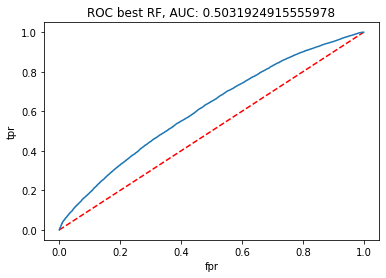

In [52]:
from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, predicted_scores[:,1], pos_label=1)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(roc_auc_score(y_test, predicted_labels)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

#### Matriz de confusión

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted_labels)

array([[   90, 12268],
       [   39, 43403]])

#### Accuracy

In [54]:
from sklearn.metrics import accuracy_score 
accuracy_score(y_test, predicted_labels)

0.7794444444444445

In [55]:
#### Precision, recall, thresholds
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_2 = precision_recall_curve(y_test, predicted_scores[:,1], pos_label=1)

In [56]:
thresholds_2 = np.append(thresholds_2, 1)

In [57]:
(precision.shape, recall.shape, thresholds_2.shape)

((54370,), (54370,), (54370,))

#### Reporte de métricas

In [ ]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({'threshold': thresholds_2,'precision': precision,
                    'recall': recall})
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [ ]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

¿Cuál es el threshold que tendríamos que escoger para que no tengamos más de 6% de FP?

In [ ]:
negocio = metrics_report[metrics_report.fpr <= 0.06]
negocio

# Modeling

In [59]:
def magic_loop(algorithms, df):
    """
    Evaluación de metodología Magic Loop en la etapa de modeling
    :param: Algoritmos a evaluar y el dataframe
    :return: mejor modelo
    """
    # Procesamiento de datos
    X = df
    y = df.label
    X = pd.DataFrame(X.drop(['label'], axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=None)

    # Magic Loop
    algorithms_dict = {'tree': 'tree_grid_search',
                       'random_forest': 'rf_grid_search',
                      'logistic': 'logistic_grid_search'}
    grid_search_dict = {'tree_grid_search': {'max_depth': [5, 10, 15, None],
                                             'min_samples_leaf': [3, 5, 7]},
                        'rf_grid_search': {'n_estimators': [30, 50, 100],
                                           'max_depth': [5, 10, 15],
                                           'min_samples_leaf': [3, 5, 10]},
                        'logistic_grid_search':{'C':np.logspace(-3,3,7), 
                                                'penalty':['l1','l2']}}

    estimators_dict = {'tree': DecisionTreeClassifier(random_state=1111),
                       'random_forest': RandomForestClassifier(oob_score=True, random_state=2222),
                       'logistic': LogisticRegression(random_state=3333)}

    # Empezar proceso
    best_estimators = []
    start_time = time.time()
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]

        tscv = TimeSeriesSplit(n_splits=5)
        gs = GridSearchCV(estimator, grid_params, scoring='precision', cv=tscv, n_jobs=3)

        # train
        gs.fit(X_train, y_train)
        # best estimator
        best_estimators.append(gs)

    print("Tiempo de ejecución: ", time.time() - start_time)

    # Seleccionar el de mejor desempeño
    models_develop = [best_estimators[0].best_score_, best_estimators[1].best_score_]
    max_score = max(models_develop)
    max_index = models_develop.index(max_score)
    best_model = best_estimators[max_index]

    print('Mejor modelo: ', best_model.best_estimator_)
    print('Mejor desempeño: ', best_model.best_score_)
    return best_model

def save_models(model, path = 'output/model_loop_DPA.pkl'):
    save_df(model, path)


    


In [60]:
print("Iniciando modelado")
start_time = time.time()
# Cargamos datos
#df = load_features(path)
algorithms = ['tree', 'random_forest']
# Obtenemos el modelo
model = magic_loop(algorithms, df)
# Guardamos el modelo
#save_models(model)
pickle.dump(df, open('output/model_loop_DPA.pkl', "wb"))##en jupyter
print("Terminó modelado en ", time.time() - start_time)

Iniciando modelado
Tiempo de ejecución:  421.9023823738098
Mejor modelo:  DecisionTreeClassifier(min_samples_leaf=7, random_state=1111)
Mejor desempeño:  0.7941877457044221
Terminó modelado en  423.2314672470093
